In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from numpy.testing import assert_equal, assert_allclose

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.types as t
import pyspark.sql.functions as f
from pyspark.sql.functions import col, count, udf, when, avg
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer

from figure_labeler import *

from IPython.display import HTML
HTML('''
<script
    src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js ">
</script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
    value="Click here to toggle on/off the raw code."></form>
''')

In [2]:
fl = FigureLabeler();
pd.options.mode.chained_assignment = None

<h1 style="text-align:center;">Miley Cyrus's Spotify Chart Performance </h1>
<hr>

<a name="top"></a>
#### Table of Contents:

[ref0]: #exec_summary
- [Executive Summary][ref0]

[ref1]: #prob_stat
- [Problem Statement][ref1]

[ref2]: #motiv
- [Motivation][ref2]

[ref3]: #dat_sor
- [Data Source][ref3]

[ref4]: #dat_prep
- [Data Preprocessing][ref4]

[ref5]: #dat_expl
- [Data Exploration][ref5]

[ref6]: #res_dis
- [Results and Discussions][ref6]

[ref7]: #conc
- [Conclusion and Recommendations][ref7]

[ref8]: #refe
- [References][ref8]

***

<a name="exec_summary"></a>
## Executive Summary
In this section, provide a concise overview of the project, highlighting the key findings and insights derived from the Spotify Charts dataset analysis.
***

Miley Cyrus, a prominent pop artist, has been analyzing her performance on Spotify to refine her music strategy. To assist in this evaluation, data from the Spotify Charts dataset covering January 1, 2017, to December 31, 2021, was utilized. The analysis reveals the frequency and ranking of her songs on the 'top200' chart, highlighting significant tracks such as 'Prisoner (feat. Dua Lipa)', which led the charts 25 times and accumulated over 573 million streams. Key insights include the distribution of her hits across different regions, with Italy showing a notable concentration of top rankings. Visualizations underscore the consistency of her chart presence and streaming success, providing a comprehensive view of Miley Cyrus’s impact and performance trends in the global music industry.

[ref]: #top
[Back to Table of Contents][ref]

<a name="prob_stat"></a>
## Problem Statement
In this section, we address the challenge of evaluating Miley Cyrus's performance on Spotify to gain insights into her musical impact and chart success.
***

By utilizing the Spotify Charts dataset from January 1, 2017, to December 31, 2021, the analysis aims to identify key trends and patterns in her chart appearances and streaming metrics. The focus is on understanding the distribution of her songs on the 'top200' chart, pinpointing the most successful tracks based on streams and rankings, and examining regional variations in chart performance. Visualizations include trend plots and ranking charts to highlight the consistency of her hits and their impact across different regions. This approach seeks to provide a clear picture of Miley Cyrus’s musical achievements and strategic insights into her ongoing success in the global music industry.

[ref]: #top
[Back to Table of Contents][ref]

<a name="motiv"></a>
## Motivation
In this section, the motivation arises from the need to understand the evolving dynamics of music consumption and artist performance in the digital age.
***

With streaming platforms like Spotify playing a crucial role in shaping music trends, it is essential to leverage data analytics to gain insights into an artist's chart performance and audience engagement. By analyzing Miley Cyrus's performance data, we aim to uncover patterns in her musical success, assess the impact of her top tracks, and identify regional preferences. This approach seeks to enhance traditional methods of evaluating musical impact by providing data-driven insights into streaming trends and chart performance, ultimately helping to refine marketing strategies and optimize artist engagement with global audiences.

[ref]: #top
[Back to Table of Contents][ref]

<a name="dat_sor"></a>
## Data Source
In this section, the data source of the study is indicated.
***

The analysis adopts a systematic approach by obtaining the "Spotify Charts" dataset from Kaggle, authored by Dave, D. & Dalwadi, A. (2022, February 9). This dataset provides detailed insights into Spotify track performances, including rankings, streaming numbers, and artist data. 

*Click this for the dataset:* [Dataset Link](https://www.kaggle.com/datasets/dhruvildave/spotify-charts)

[ref]: #top
[Back to Table of Contents][ref]

<a name="dat_prep"></a>
## Data Preprocessing
***

In this section, the dataset is loaded into a PySpark SQL and initial data cleaning steps are performed to ensure data quality and completeness.

In [3]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = (
    SparkSession
        .builder
        .master('local[*]')
        .getOrCreate()
)

In [4]:
artist_df = spark.read.csv(
    'charts.csv',
    sep=',', header=True, inferSchema=True
)

In [5]:
artist_df.show()

+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+-------+
|               title|rank|      date|              artist|                 url|   region| chart|        trend|streams|
+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+-------+
|Chantaje (feat. M...|   1|2017-01-01|             Shakira|https://open.spot...|Argentina|top200|SAME_POSITION| 253019|
|Vente Pa' Ca (fea...|   2|2017-01-01|        Ricky Martin|https://open.spot...|Argentina|top200|      MOVE_UP| 223988|
|Reggaetón Lento (...|   3|2017-01-01|                CNCO|https://open.spot...|Argentina|top200|    MOVE_DOWN| 210943|
|              Safari|   4|2017-01-01|J Balvin, Pharrel...|https://open.spot...|Argentina|top200|SAME_POSITION| 173865|
|         Shaky Shaky|   5|2017-01-01|        Daddy Yankee|https://open.spot...|Argentina|top200|      MOVE_UP| 153956|
|         Traicionera|   6|2017-01-01|  

In [6]:
artist_df = (
    artist_df
        .withColumn("rank", f.col("rank").cast(t.LongType()))
        .withColumn("date", f.col("date").cast(t.DateType()))
        .withColumn("streams", f.col("streams").cast(t.IntegerType()))
)

In [7]:
artist_df = (
    artist_df
        .fillna({
            'title': 'Unknown Title',
            'rank': 200,
            'date': '1970-01-01',
            'artist': 'Unknown Artist',
            'streams': 0
        })
)

In [8]:
artist_df = artist_df.filter(
    f.col("title").isNotNull() &
    f.col("rank").isNotNull() &
    f.col("date").isNotNull() &
    f.col("artist").isNotNull()
)

In [9]:
artist_df = artist_df.withColumn("rank", f.col("rank").cast(t.LongType())).withColumn("date", f.col("date").cast(t.DateType())).withColumn("streams", f.col("streams").cast(t.IntegerType()))

In [10]:
artist_df

DataFrame[title: string, rank: bigint, date: date, artist: string, url: string, region: string, chart: string, trend: string, streams: int]

In [11]:
artist_df.createOrReplaceTempView("charts")

In [12]:
palette = {
    'Prisoner (feat. Dua Lipa)': '#AA336A',
    'Malibu': '#5C4033',
    'Midnight Sky': '#191970',
    "Mother' Daughter": "8B0000"
}

[ref]: #top
[Back to Table of Contents][ref]

<a name="dat_expl"></a>
## Data Exploration
***

In this section, explore the dataset to uncover insights and patterns related to player attributes and performance.

In [13]:
fl.table_caption("Determining Data Timeline Range",
                 "The table shows the earliest and latest dates for 'top200' entries from the 'charts' dataset, displayed as a Pandas DataFrame.")

spark.sql('''
SELECT MIN(date) begin, MAX(date) end 
FROM charts 
WHERE chart = 'top200';
''').show()

+----------+----------+
|     begin|       end|
+----------+----------+
|2017-01-01|2021-12-31|
+----------+----------+



In [14]:
fl.table_caption("Top 10 Artists from 'top200' Chart",
                 "The table lists the first 10 entries from the 'top200' chart in the 'charts' dataset.")

spark.sql('''
SELECT * 
FROM charts 
WHERE chart='top200' 
LIMIT 10;
''').show()

+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+-------+
|               title|rank|      date|              artist|                 url|   region| chart|        trend|streams|
+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+-------+
|Chantaje (feat. M...|   1|2017-01-01|             Shakira|https://open.spot...|Argentina|top200|SAME_POSITION| 253019|
|Vente Pa' Ca (fea...|   2|2017-01-01|        Ricky Martin|https://open.spot...|Argentina|top200|      MOVE_UP| 223988|
|Reggaetón Lento (...|   3|2017-01-01|                CNCO|https://open.spot...|Argentina|top200|    MOVE_DOWN| 210943|
|              Safari|   4|2017-01-01|J Balvin, Pharrel...|https://open.spot...|Argentina|top200|SAME_POSITION| 173865|
|         Shaky Shaky|   5|2017-01-01|        Daddy Yankee|https://open.spot...|Argentina|top200|      MOVE_UP| 153956|
|         Traicionera|   6|2017-01-01|  

In [15]:
fl.table_caption("Top 10 Artists from the 'viral50' Chart",
                 "The table lists the first 10 entries from the 'viral50' chart in the 'charts' dataset.")

spark.sql('''
SELECT * 
FROM charts 
WHERE chart='viral50' 
LIMIT 10;
''').show()

+-----------+----+----------+----------+--------------------+----------+-------+-------------+-------+
|      title|rank|      date|    artist|                 url|    region|  chart|        trend|streams|
+-----------+----+----------+----------+--------------------+----------+-------+-------------+-------+
|       Boys|  13|2017-08-01|Charli XCX|https://open.spot...|    Latvia|viral50|      MOVE_UP|      0|
|    Hold Me|  19|2017-08-01|     R3HAB|https://open.spot...|Luxembourg|viral50|    MOVE_DOWN|      0|
|  Hola Hola|  40|2017-08-01|      KARD|https://open.spot...|      Peru|viral50|    NEW_ENTRY|      0|
|    Cuídate|   4|2017-08-01|   Zetazen|https://open.spot...|     Spain|viral50|SAME_POSITION|      0|
|       Boys|  13|2017-08-01|Charli XCX|https://open.spot...|    Taiwan|viral50|    MOVE_DOWN|      0|
|   DINOSAUR|  14|2017-08-01|      AKMU|https://open.spot...|    Taiwan|viral50|      MOVE_UP|      0|
| Spice Girl|  33|2017-08-02|     Aminé|https://open.spot...|    Canada|v

In [16]:
fl.table_caption("Total Number of Entries in 'Top 200' Chart",
                 "The table shows the total number of entries by all the singers in TOP 200.")

spark.sql('''
SELECT COUNT(*) n
FROM charts 
WHERE chart = 'top200';
''').show()

+--------+
|       n|
+--------+
|20318183|
+--------+



In [17]:
fl.table_caption("Total Number of Entries in 'viral50' Chart",
                 "The table shows the total number of entries in the 'viral50' chart.")

spark.sql('''
SELECT COUNT(*) AS n
FROM charts 
WHERE chart = 'viral50';
''').show()

+-------+
|      n|
+-------+
|5848001|
+-------+



In [18]:
fl.table_caption("Total Number of Songs by Miley Cyrus in 'Top 200'",
                 "The table displays the count of distinct songs by Miley Cyrus that have appeared in the 'top200' chart.")

spark.sql('''
SELECT count(distinct title) NoOfSongs 
FROM charts 
WHERE artist LIKE '%Miley Cyrus%' 
AND chart = 'top200';
''').show()

+---------+
|NoOfSongs|
+---------+
|       40|
+---------+



In [19]:
fl.table_caption("Total Number of Songs by Miley Cyrus in 'Viral 50'",
                 "The table displays the count of distinct songs by Miley Cyrus that have appeared in the 'viral50' chart.")

spark.sql('''
SELECT COUNT(DISTINCT title) AS NoOfSongs
FROM charts 
WHERE artist LIKE '%Miley Cyrus%' 
AND chart = 'viral50';
''').show()

+---------+
|NoOfSongs|
+---------+
|       28|
+---------+



In [20]:
fl.table_caption("Count of Miley Cyrus Appearances in 'top200' and 'viral50'",
                 "The table counts the number of times Miley Cyrus has appeared in the 'top200' and 'viral50' charts.")

spark.sql('''
SELECT 
    SUM(CASE WHEN chart = 'top200' THEN 1 ELSE 0 END) AS N_InTop200,
    SUM(CASE WHEN chart = 'viral50' THEN 1 ELSE 0 END) AS N_InViral50
FROM charts 
WHERE artist LIKE '%Miley Cyrus%';
''').show()

+----------+-----------+
|N_InTop200|N_InViral50|
+----------+-----------+
|     35696|       4756|
+----------+-----------+



In [21]:
fl.table_caption("Occurrences of Miley Cyrus in 'Top 200' and 'viral50' by Artist",
                 "The table lists the number of times Miley Cyrus has appeared in the 'top200' and 'viral50' chart, along with the count for each artist, sorted by occurrence.")

spark.sql('''
SELECT 
    artist, 
    SUM(CASE WHEN chart = 'top200' THEN 1 ELSE 0 END) AS Count_Top200,
    SUM(CASE WHEN chart = 'viral50' THEN 1 ELSE 0 END) AS Count_Viral50
FROM charts 
WHERE artist LIKE '%Miley Cyrus%' 
GROUP BY artist 
ORDER BY Count_Top200 DESC;
''').toPandas()

,artist,Count_Top200,Count_Viral50
0,Miley Cyrus,35519,4743
1,"Miley Cyrus, Mark Ronson",117,0
2,"Miley Cyrus, WATT, Elton John, Yo-Yo Ma, Rober...",29,6
3,"Miley Cyrus, Swae Lee, Mike WiLL Made-It",20,0
4,"Miley Cyrus, Joan Jett & The Blackhearts",8,0
5,"Mark Ronson, Miley Cyrus",3,0
6,"Mike WiLL Made-It, Miley Cyrus, Wiz Khalifa, J...",0,7


In [22]:
fl.table_caption("Top 10 Songs by Miley Cyrus",
                 "The table lists the top 10 songs by Miley Cyrus based on total streams, ordered from highest to lowest.")

top_songs_df = spark.sql('''
SELECT title, SUM(streams) streams 
FROM charts 
WHERE artist LIKE '%Miley Cyrus%' 
AND streams IS NOT NULL 
GROUP BY title 
ORDER BY streams DESC 
LIMIT 10;''').toPandas()

top_songs_df.head(10)

,title,streams
0,Prisoner (feat. Dua Lipa),573927886
1,Midnight Sky,466928234
2,Malibu,435514642
3,Mother's Daughter,165313024
4,Slide Away,153622503
5,Party In The U.S.A.,89242067
6,Heart Of Glass (Live from the iHeart Festival),51693430
7,When I Look At You,41096102
8,Angels Like You,39026652
9,Plastic Hearts,17046985


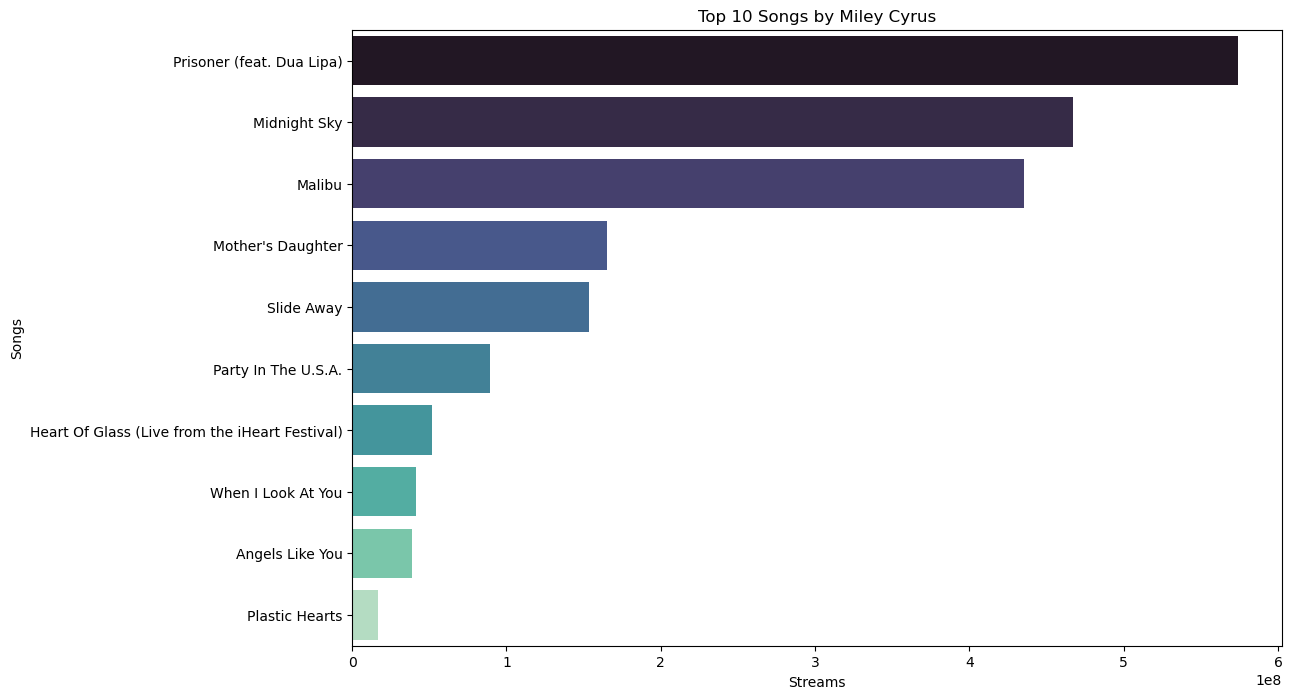

In [23]:
plt.figure(figsize=(12, 8))
sns.barplot(x="streams", y="title", data=top_songs_df, palette ="mako")
plt.title("Top 10 Songs by Miley Cyrus")
plt.xlabel("Streams")
plt.ylabel("Songs")
plt.show()

fl.fig_caption("Top 10 Songs by Miley Cyrus",
               "The bar graph illustrates the top 10 songs of Miley Cyrus based on its streams.")

The bar graph demonstrates the top ten songs of Miley Cyrus in the 200s chart based on its streams. The x-axis shows the number or times it was streamed and the y-axis shows the songs of Miley Cyrus. As seen in the x-axis, there is a “le” which means multiplied to the power of. Now observing the graph, it can be noticed that the most stream song is Prisoner (feat. Dua Lipa) followed by midnight sky and the least streamed song is Plastic Hearts. The gap between the most and least streamed song occurs a significant difference as listeners are more inclined to the song, Prisoner, than Miley’s other songs. 

In [24]:
fl.table_caption("Frequency of Miley Cyrus Songs in 'Top 200'",
                 "The table shows how many times each song by Miley Cyrus has appeared in the 'top200' chart, ordered by frequency.")

frequency_df = spark.sql('''
SELECT title, count(title) AS count 
FROM charts 
WHERE artist LIKE '%Miley Cyrus%' 
AND chart = 'top200' 
GROUP BY title 
ORDER BY count DESC;
''').toPandas()

frequency_df.head(10)

,title,count
0,Prisoner (feat. Dua Lipa),9159
1,Malibu,6969
2,Midnight Sky,6880
3,Party In The U.S.A.,3672
4,Mother's Daughter,2962
5,Slide Away,2392
6,When I Look At You,876
7,Angels Like You,752
8,Heart Of Glass (Live from the iHeart Festival),473
9,Younger Now,395


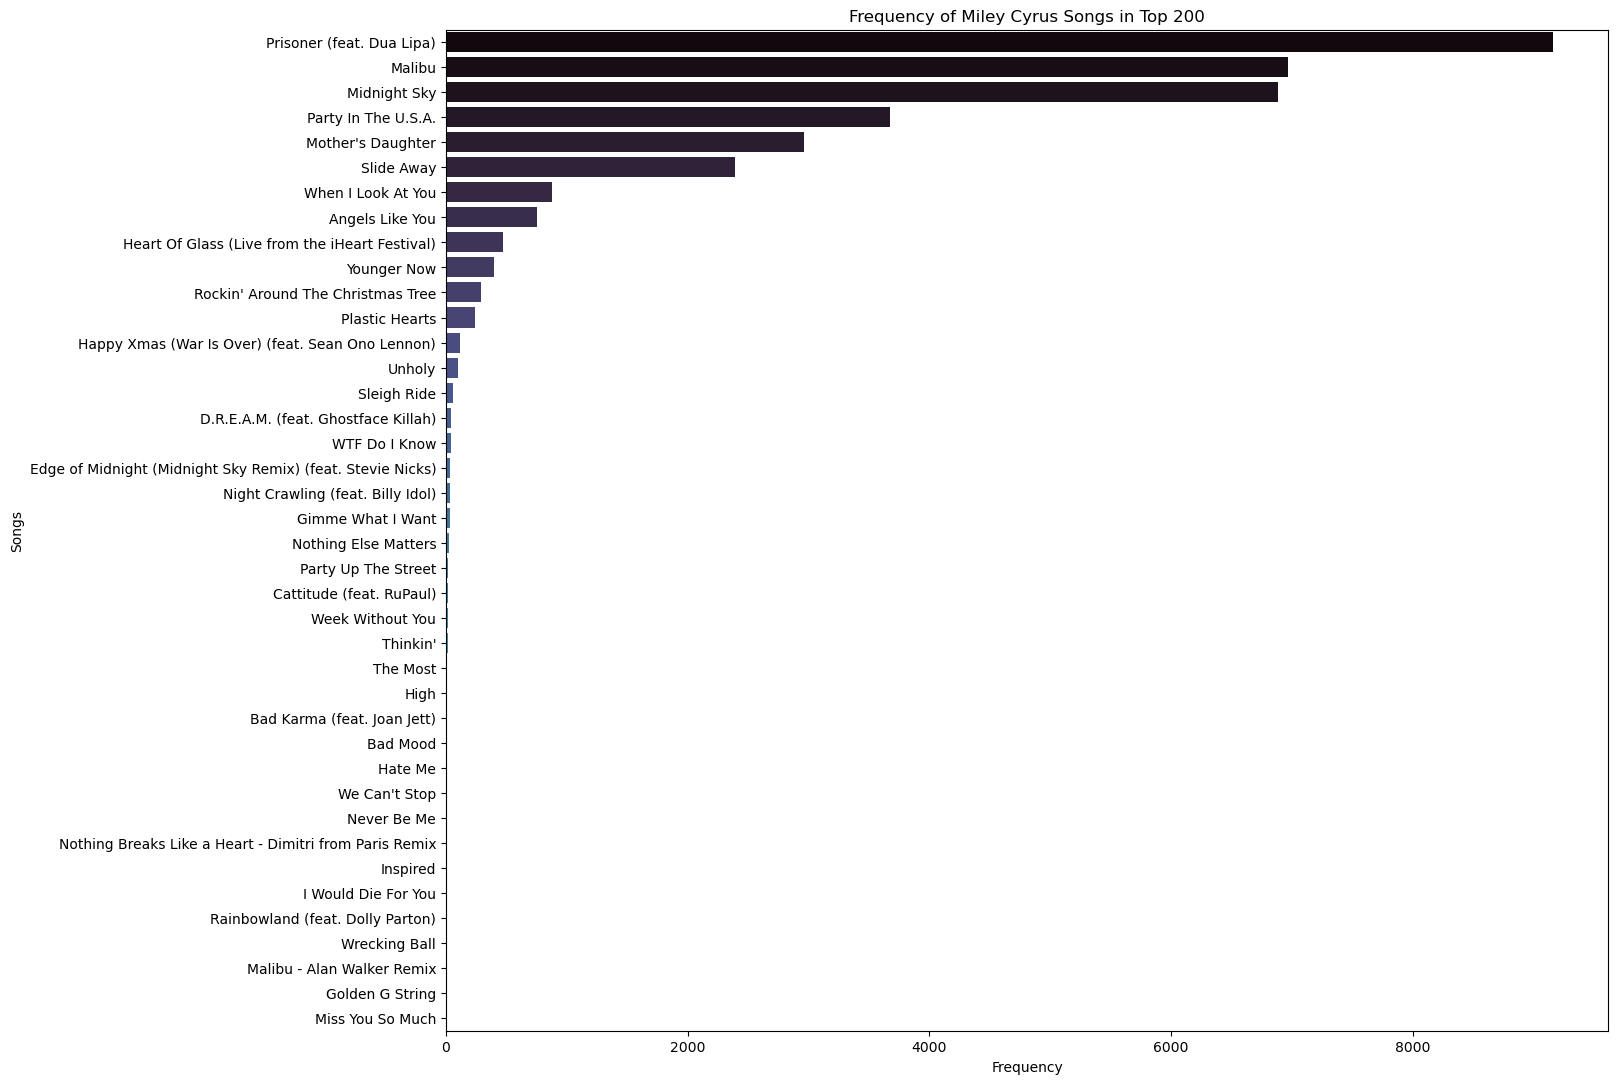

In [25]:
plt.figure(figsize=(15, 13))
sns.barplot(x="count", y="title", data=frequency_df, palette="mako")
plt.title("Frequency of Miley Cyrus Songs in Top 200")
plt.xlabel("Frequency")
plt.ylabel("Songs")
plt.show()

fl.fig_caption("Frequency of Miley Cyrus Songs in Top 200",
               "The bar graph illustrates the songs of Miley Cyrus under the top 200 charts and its frequency.")

The bar graph illustrates the frequency of all Miley Cyrus’ songs in the top 200 chart. The x-axis shows the frequency value and the y-axis shows the songs. In relation to the previous bar graph of top ten streamed songs of Miley, the highest frequency gained is the same as the top most streamed song, which is the Prisoner (feat. Dua Lipa). As seen in the graph, the least frequency within Miley’s song is Miss You So Much. This can imply that since the song, Prisoner (feat. Dua Lipa) has the most streamed, it will also be recognized as the top appearing song in the top 200 charts. 

In [26]:
fl.table_caption("Highest Ranks Achieved by Miley Cyrus Songs",
                 "The table lists Miley Cyrus songs along with their highest ranks (1 to 5) and the number of times they reached these positions on the 'top200' chart.")

highest_df = spark.sql('''
SELECT h.title, h.rank, COUNT(c.rank) AS count
FROM (
    SELECT title, MIN(rank) AS rank 
    FROM charts 
    WHERE artist LIKE '%Miley Cyrus%' 
    AND chart = 'top200' 
    AND rank <= 5 
    GROUP BY title
) h
JOIN charts c
ON h.title = c.title AND h.rank = c.rank
WHERE c.artist LIKE '%Miley Cyrus%' 
AND c.chart = 'top200' 
GROUP BY h.title, h.rank;
''').toPandas()

highest_df.head(20)

,title,rank,count
0,Mother's Daughter,5,5
1,Malibu,2,2
2,Midnight Sky,5,1
3,Prisoner (feat. Dua Lipa),1,1


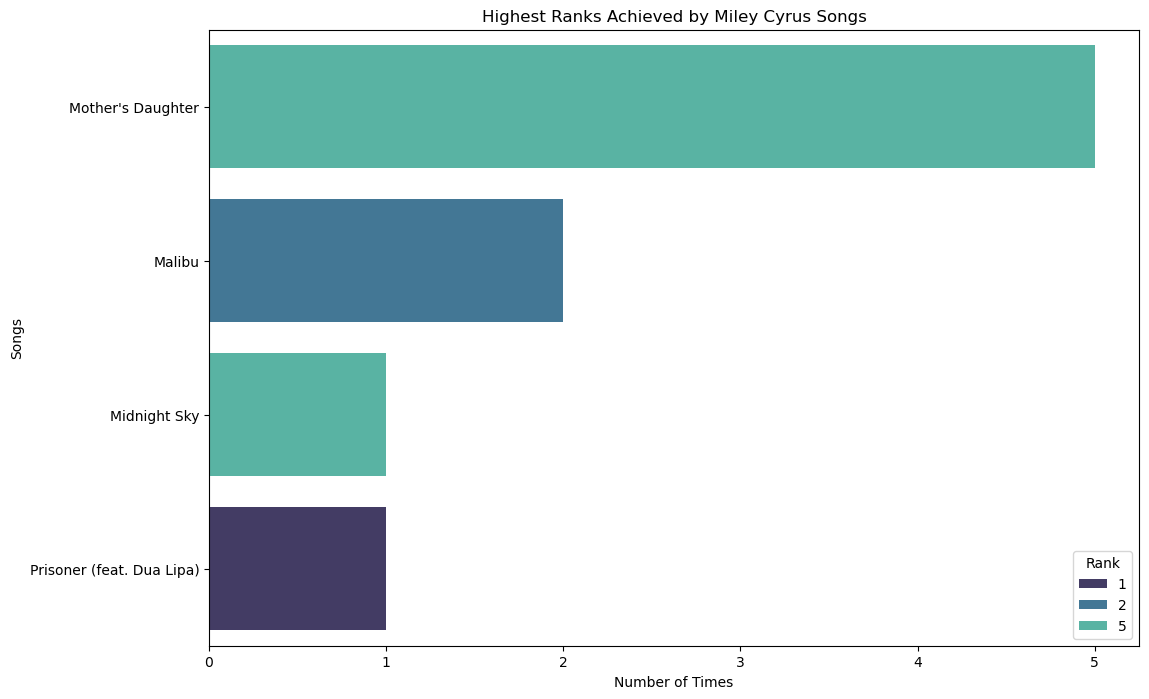

In [27]:
plt.figure(figsize=(12, 8))
sns.barplot(x="count", y="title", hue="rank", data=highest_df, palette="mako", dodge=False)
plt.title("Highest Ranks Achieved by Miley Cyrus Songs")
plt.xlabel("Number of Times")
plt.ylabel("Songs")
plt.legend(title="Rank", loc="lower right")
plt.show()

fl.fig_caption("The Highest Ranks of Miley Cyrus Songs",
               "The bar graph illustrates the songs of Miley Cyrus and its highest rank achieved in the chart.")

The bar graph shows the highest positions Miley Cyrus’ songs reached on the top 200 chart. The x-axis displays how many times each song stayed at a specific rank, while the y-axis lists the song titles. The legend indicates the ranks achieved, such as 1st, 2nd, or 5th. For example, "Prisoner" (feat. Dua Lipa) reached the 1st rank once, "Mother’s Daughter" stayed at the 5th rank five times, and "Malibu" was in the 2nd rank twice. "Midnight Sky" appeared less frequently, achieving the 5th rank only once. These songs represent Miley Cyrus' highest positions on the top 200 chart.

In [28]:
fl.table_caption("Total Number of Times Miley Cyrus Reached 1st Rank",
                 "The table shows the total number of times Miley Cyrus has achieved the 1st rank on the 'top200' chart. The count is 1, indicating that she reached the 1st rank on one occasion.")

spark.sql('''
SELECT count(*) Rank1 
FROM charts 
WHERE artist LIKE '%Miley Cyrus%' 
AND chart = 'top200' 
AND rank = 1;
''').show()

+-----+
|Rank1|
+-----+
|    1|
+-----+



In [29]:
fl.table_caption("Trends of Selected Miley Cyrus Songs in 'Top 200' Chart Over Time",
                 "The table tracks the trends of select Miley Cyrus songs ('Prisoner (feat. Dua Lipa)', 'Midnight Sky', 'Malibu') on the 'top200' chart by year, date, rank, and region.")

q = spark.sql('''
SELECT title, YEAR(date) AS year, date, rank, region 
FROM charts 
WHERE title IN ('Prisoner (feat. Dua Lipa)', 'Midnight Sky', 'Malibu') 
AND artist LIKE '%Miley Cyrus%' 
AND chart = 'top200'
ORDER BY rank ASC, date ASC;
''').toPandas()

q.head(20)

,title,year,date,rank,region
0,Prisoner (feat. Dua Lipa),2020,2020-11-27,1,Bulgaria
1,Malibu,2017,2017-05-27,2,Lithuania
2,Malibu,2017,2017-05-29,2,Lithuania
3,Prisoner (feat. Dua Lipa),2020,2020-11-20,2,Bulgaria
4,Prisoner (feat. Dua Lipa),2020,2020-11-23,2,Bulgaria
5,Malibu,2017,2017-05-12,3,Slovakia
6,Malibu,2017,2017-05-16,3,Poland
7,Malibu,2017,2017-05-17,3,Poland
8,Malibu,2017,2017-05-23,3,Lithuania
9,Malibu,2017,2017-05-26,3,Lithuania


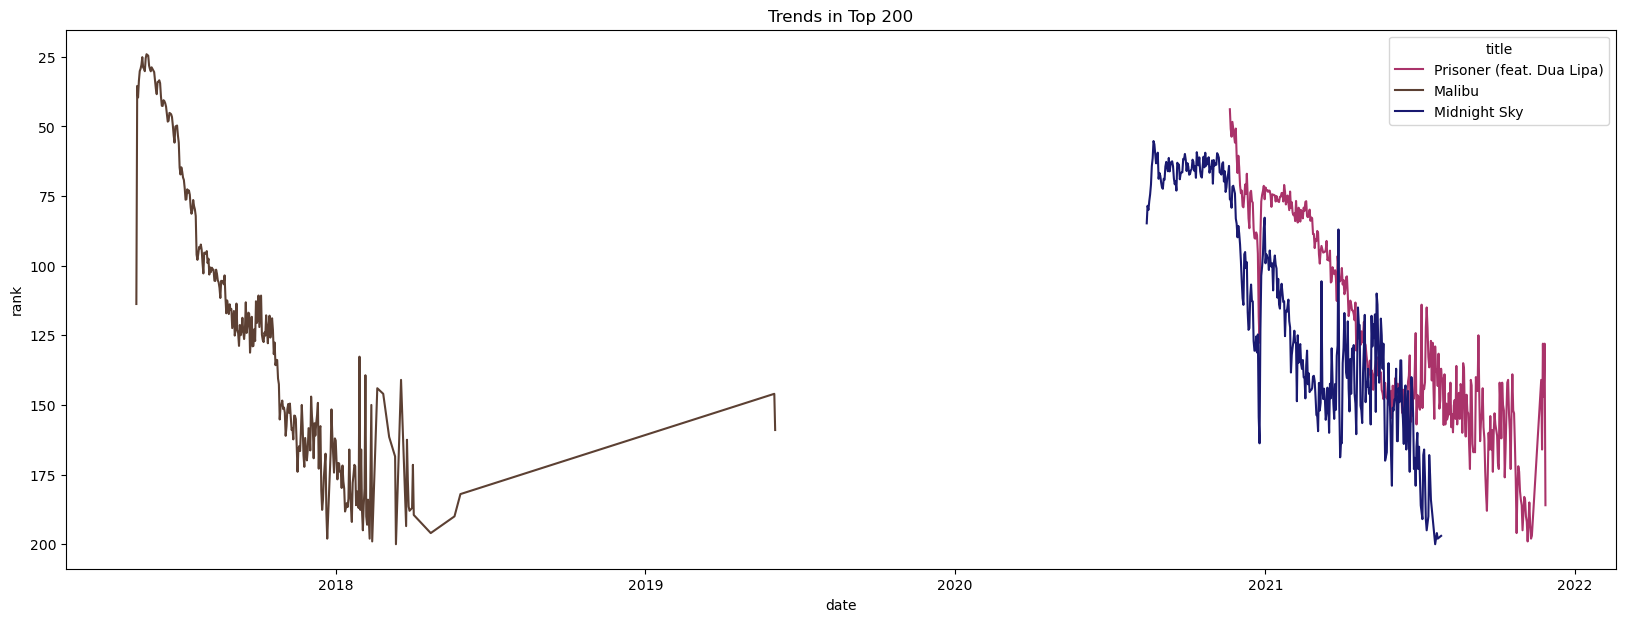

In [30]:
fig, axes = plt.subplots(figsize=(20, 7))
sns.lineplot(x='date', y='rank', data=q, hue='title', palette=palette, errorbar=None, ax=axes)
axes.invert_yaxis()
axes.set_title('Trends in Top 200')
plt.show()

fl.fig_caption("Trends in Top 200 for Selected Miley Cyrus Songs",
               "The plot illustrates the ranking trends over time for selected Miley Cyrus songs ('Prisoner (feat. Dua Lipa)', 'Midnight Sky', 'Malibu') on the 'top200' chart.")

The bar graph views the trend in the top 200 chart where the selected song by Miley Cyrus was at its peak or shiftment. The x-axis shows the date in years from 2017 to 2021 and the y-axis shows the ranking it occurred in the top 200. The purple line represents the song Prisoner (feat. Dua Lipa), the brown line represents the song Malibu, and the dark blue line represents the song Midnight Sky. 

The song Malibu has transpired differently through the years. Between the 2017 and 2018 it fluctuates in its ranking mid year and declines progressively at the start of 2018 with over nearing a 200 ranking and maintains its ranking until year 2020. Meanwhile, the song Prisoner (feat. Dua Lipa) has seen only 1 year from 2021 to 2022. This can be associated with the fact that the song was only released during this time of the year. The song Prisoner has gained a high ranking towards the start of 2021 and fluctuated in the end of 2021 with nearing almost 200 ranking. Lastly, the song Midnight Sky has seen a high ranking in the mid year of 2020 towards the year of 2021, but it fluctuates in ranking going to almost 200 mid year of 2021. This trends implies the significany or influence of the songs gained in specific year whether its high in its ranking or not.

In [31]:
fl.table_caption("Trends of Selected Songs of Miley Cyrus in 'Viral 50' Chart Over Time",
                 "The table displays the trends of selected songs selected Miley Cyrus songs ('Prisoner (feat. Dua Lipa)', 'Midnight Sky', 'Malibu') on the 'viral50' chart, including their date, rank, and region.")

p = spark.sql('''
SELECT title, date, rank, region 
FROM charts 
WHERE title IN ('Prisoner (feat. Dua Lipa)', 'Midnight Sky', 'Malibu') 
AND chart='viral50';
''').toPandas()

p.head(20)

,title,date,rank,region
0,Malibu,2017-08-14,31,Argentina
1,Malibu,2017-08-15,31,Argentina
2,Malibu,2017-08-16,32,Argentina
3,Malibu,2017-08-17,28,Argentina
4,Malibu,2018-01-09,46,Denmark
5,Malibu,2018-01-10,38,Denmark
6,Malibu,2018-01-11,44,Denmark
7,Malibu,2018-01-12,45,Denmark
8,Malibu,2018-01-13,35,Denmark
9,Malibu,2018-01-14,40,Denmark


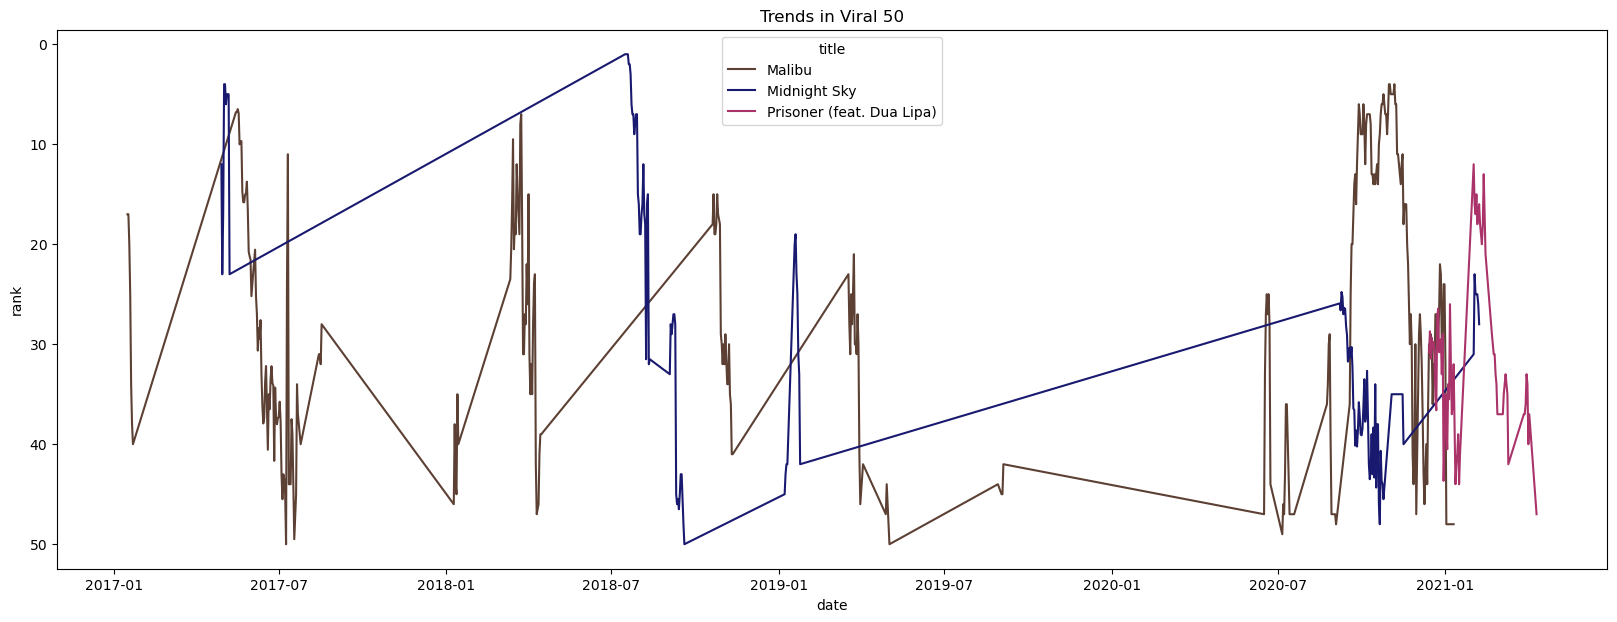

In [32]:
fig, axes = plt.subplots(figsize=(20,7))
sns.lineplot(x='date', y='rank', data=p, hue='title', palette=palette, errorbar=None, ax=axes).set_title('Trends in Viral 50')
axes.invert_yaxis()
plt.show()

fl.fig_caption("Trends in 'Viral 50' for Selected Songs of Miley Cyrus",
               "The plot shows the ranking trends over time for selected songs ('Prisoner (feat. Dua Lipa)', 'Midnight Sky', 'Malibu') on the 'viral50' chart.")

The bar graph views the trend in the viral 50 songs where Miley's selected song was at its peak or shiftment. The x-axis shows the date in years from 2017 to 2021 and the y-axis shows the ranking it occurred in the top 50. The purple line represents the song Prisoner (feat. Dua Lipa), the brown line represents the song Malibu, and the dark blue line represents the song Midnight Sky. 

The song Malibu has seen a high ranking mid year of 2017 and goes up to 50th ranking, however, its ranking grows again mid year of 2018 with the rank of 10 and ranges it ranks from 25 to 50 in the year 2019 to 2020. In 2020 to 2021, the song Malibu goes high in its ranking nearing the rank 10. Following that is the song, Midnight sky that has a high ranking mid year of 2017 to the first few months of 2018 and fluctuates to a ranking in 2019 towards 2021. Lastly, the song Prisoner (feat. Dua Lipa) has a low ranking between 25 to 40 rank by the end of 2020 and and goes up to 10 in ranking entering 2021 and goes down its ranking once more. 

In [33]:
fl.table_caption("Ranking Statistics for Miley Cyrus Songs",
                 "The table provides the highest, lowest, and average ranks of Miley Cyrus's songs on the 'top200' chart.")

ranking_stats_df = spark.sql('''
SELECT Title, MIN(rank) AS Highest, MAX(rank) AS Lowest, AVG(rank) AS Avg 
FROM charts 
WHERE artist LIKE '%Miley Cyrus%' 
AND chart = 'top200' 
GROUP BY Title 
ORDER BY Highest
LIMIT 10;
''').toPandas()

ranking_stats_df.head(10)

,Title,Highest,Lowest,Avg
0,Prisoner (feat. Dua Lipa),1,200,93.601157
1,Malibu,2,200,84.426747
2,Mother's Daughter,5,200,82.725861
3,Midnight Sky,5,200,84.340843
4,Slide Away,11,200,82.900920
5,When I Look At You,11,200,133.787671
6,Happy Xmas (War Is Over) (feat. Sean Ono Lennon),17,200,117.324786
7,Unholy,17,200,123.489796
8,Heart Of Glass (Live from the iHeart Festival),19,200,118.095137
9,Rockin' Around The Christmas Tree,22,200,113.868966


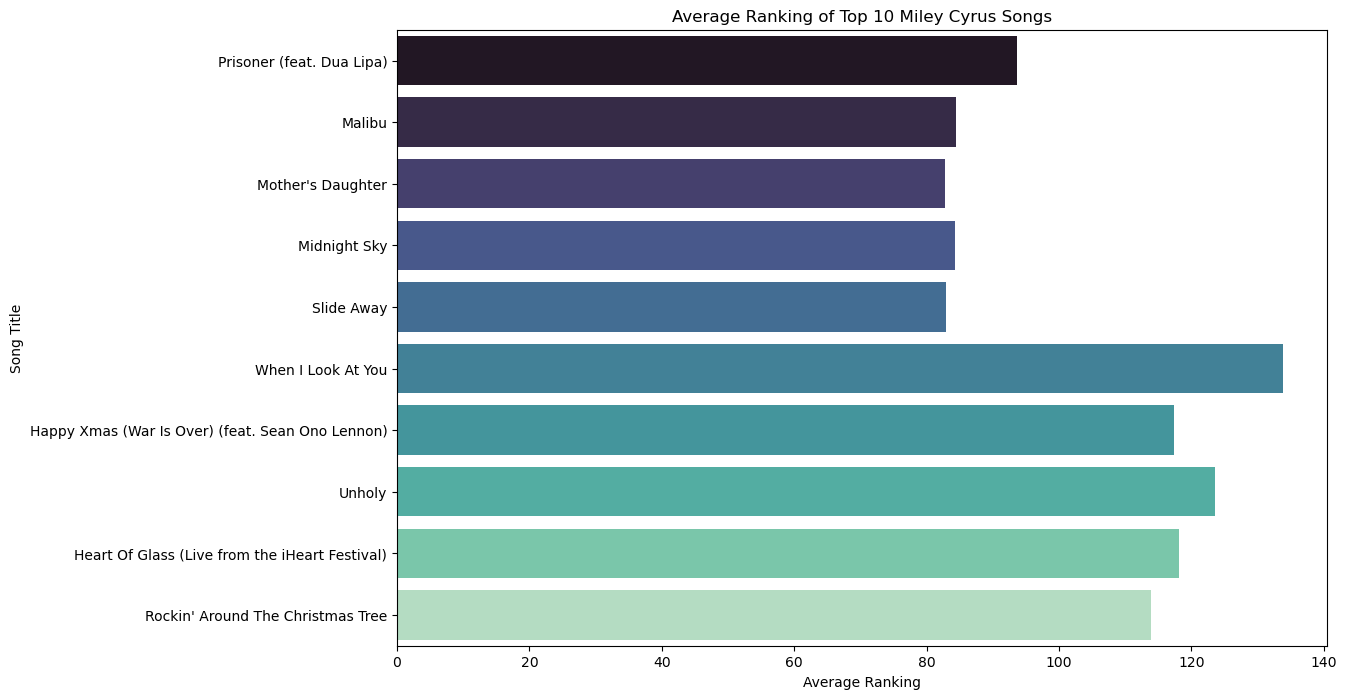

In [34]:
ranking_stats = ranking_stats_df.melt(id_vars="Title", value_vars=["Avg"], 
                                      var_name="Rank_Type", value_name="Rank_Value")

plt.figure(figsize=(12, 8))
sns.barplot(x="Rank_Value", y="Title", data=ranking_stats, palette="mako")
plt.title("Average Ranking of Top 10 Miley Cyrus Songs")
plt.xlabel("Average Ranking")
plt.ylabel("Song Title")
plt.show()

fl.fig_caption("Top 10 Ranking Statistics for Miley Cyrus Songs",
               "The bar graph illustrates the average ranks of the top ten songs of Miley Cyrus on the 'top200' chart.")

The bar graph displays the average ranking of Miley Cyrus’s songs in the ‘Top 200’ chart. The x-axis shows the average ranking, while the y-axis lists the top 10 songs in the chart. Based on the graph, **"Mother's Daughter"** has an average ranking of around 83, indicating it generally performed well, ranking near 83rd place. In contrast, **"When I Look at You"** has a lower average ranking of around 134, suggesting it typically ranked around 134th place, showing relatively weaker performance. Interestingly, despite being a top performer, **"Prisoner (feat. Dua Lipa)"** has an average ranking of 93.60, meaning that although it performs well compared to other songs, its average ranking is still around 94th place.

[ref]: #top
[Back to Table of Contents][ref]

<a name="res_dis"></a>
## Results and Discussions
In this section, we present the findings from our data exploration and discuss their implications for understanding Miley Cyrus’s chart performance and streaming success.
***

**Top Songs by Streams:**
    
    "Prisoner (feat. Dua Lipa)" is Miley Cyrus's most popular song with over 573 million streams. Other top songs include "Midnight Sky" and "Malibu", showing strong listener engagement.

**Frequency of Chart Appearances:**

    "Prisoner" also appears the most frequently on the 'top200' chart, showing up 9,159 times. "Malibu" and "Midnight Sky" follow closely. These frequent appearances highlight the songs' ongoing popularity.

**Regional Performance:**

    Miley Cyrus's songs are especially popular in Italy, indicating a strong fanbase there. "Prisoner" even reached the top spot in Bulgaria.

**Chart Trends Over Time:**
   
    "Malibu" had fluctuating ranks between 2017 and 2018 before leveling out, while "Prisoner" had a strong start in 2021. This helps us see how her songs have performed over time.

**Highest Achieved Ranks:**

    "Prisoner" reached the number one rank once, while "Malibu" reached number two multiple times. This shows their competitive edge in the music charts.

**Overall Chart Performance:**

    Miley Cyrus has a total of 35,696 appearances on the 'top200' chart with 40 different songs, demonstrating her strong presence and influence in the music industry.

The analysis reveals that Miley Cyrus's songs "Prisoner" and "Malibu" are very popular and often appear on the charts. It also highlights that Italy is a significant region for her music. These findings can guide her team in focusing their marketing efforts more effectively and understanding what her fans enjoy the most. By targeting areas like Italy and promoting popular tracks, they can better connect with her audience and boost her overall success.

[ref]: #top
[Back to Table of Contents][ref]

<a name="conc"></a>
## Conclusion and Recommendations
In this section, we will summarize our findings and provide recommendations based on the analysis performed.
***

Miley Cyrus has shown strong and consistent performance on Spotify charts, with standout hits like "Prisoner" and "Malibu" enjoying high engagement and frequent chart appearances. Italy stands out as a significant market where her music resonates strongly with listeners. This analysis confirms Miley Cyrus's influential presence in the music industry.

To build on her success, it is recommended to focus on promoting high-performing songs such as "Prisoner" and "Malibu," which continue to attract attention and engage fans. Investing in targeted marketing efforts and live performances in Italy can further leverage the strong fanbase there. Additionally, using insights from chart performance trends will help in planning future releases and promotional campaigns more effectively.

Expanding her reach to other regions where her music is also well-received can help diversify her global presence. By analyzing chart performance trends, her team can make informed decisions about when to release new music and how to tailor promotions to current listener preferences. Exploring new opportunities in various regions will support growth in her fan base and strengthen her international presence, ensuring her music connects with audiences around the world.

[ref]: #top
[Back to Table of Contents][ref]

<a name="refe"></a>
## References
***

Dave, D. & Dalwadi, A. (2022, February 9). Spotify Charts. Kaggle. https://www.kaggle.com/datasets/dhruvildave/spotify-charts

[ref]: #top
[Back to Table of Contents][ref]